# Model Accuracy Comparison

Compare field-level accuracy between the current model and a competing model across 195 mixed documents (invoices, receipts, bank statements).

## Overview
- **Current Model**: Results from our evaluation pipeline
- **Competing Model**: Field-level accuracy from external CSV
- **Schema**: 17 common fields across document types

---
## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from typing import Any
import warnings

warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 3)

In [2]:
# =============================================================================
# CONFIGURATION - Update these paths before running
# =============================================================================

# Path to competing model's field-level accuracy CSV
COMPETING_MODEL_CSV = Path("../output/competing_model_accuracy.csv")

# Path to current model's results
CURRENT_MODEL_CSV = Path("../output/current_model_accuracy.csv")

# Model names for display
CURRENT_MODEL_NAME = "InternVL3-8B"
COMPETING_MODEL_NAME = "Competing Model"

# Output directory for comparison results
OUTPUT_DIR = Path("../output/comparison")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# =============================================================================
# SCHEMA FIELDS - 17 fields for comparison
# =============================================================================

SCHEMA_FIELDS = [
    "DOCUMENT_TYPE",
    "BUSINESS_ABN",
    "SUPPLIER_NAME",
    "BUSINESS_ADDRESS",
    "PAYER_NAME",
    "PAYER_ADDRESS",
    "INVOICE_DATE",
    "LINE_ITEM_DESCRIPTIONS",
    "LINE_ITEM_QUANTITIES",
    "LINE_ITEM_PRICES",
    "LINE_ITEM_TOTAL_PRICES",
    "IS_GST_INCLUDED",
    "GST_AMOUNT",
    "TOTAL_AMOUNT",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "TRANSACTION_AMOUNTS_PAID",
]

# Field categories for grouped analysis
FIELD_CATEGORIES = {
    "Identity": ["DOCUMENT_TYPE", "BUSINESS_ABN", "SUPPLIER_NAME"],
    "Address": ["BUSINESS_ADDRESS", "PAYER_NAME", "PAYER_ADDRESS"],
    "Dates": ["INVOICE_DATE", "STATEMENT_DATE_RANGE", "TRANSACTION_DATES"],
    "Line Items": ["LINE_ITEM_DESCRIPTIONS", "LINE_ITEM_QUANTITIES", "LINE_ITEM_PRICES", "LINE_ITEM_TOTAL_PRICES"],
    "Financial": ["IS_GST_INCLUDED", "GST_AMOUNT", "TOTAL_AMOUNT", "TRANSACTION_AMOUNTS_PAID"],
}

# Critical fields (require high accuracy)
CRITICAL_FIELDS = ["BUSINESS_ABN", "GST_AMOUNT", "TOTAL_AMOUNT", "SUPPLIER_NAME"]

print(f"Schema fields: {len(SCHEMA_FIELDS)}")
print(f"Field categories: {list(FIELD_CATEGORIES.keys())}")

Schema fields: 17
Field categories: ['Identity', 'Address', 'Dates', 'Line Items', 'Financial']


---
## 2. Data Loading

In [4]:
def load_competing_model_data(csv_path: Path) -> pd.DataFrame:
    """
    Load competing model's field-level accuracy from CSV.
    
    Expected formats:
    - Format A: Columns = field names, single row of accuracy values
    - Format B: Columns = [Field, Accuracy] with fields as rows
    - Format C: Columns include 'field' and 'accuracy' (case-insensitive)
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded competing model CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Detect format and normalize to {field: accuracy} structure
    cols_lower = [c.lower() for c in df.columns]
    
    if 'field' in cols_lower and 'accuracy' in cols_lower:
        # Format B/C: Field and Accuracy columns
        field_col = df.columns[cols_lower.index('field')]
        acc_col = df.columns[cols_lower.index('accuracy')]
        result = pd.DataFrame({
            'field': df[field_col].str.upper(),
            'accuracy': pd.to_numeric(df[acc_col], errors='coerce')
        })
    elif len(df) == 1:
        # Format A: Single row with field names as columns
        result = pd.DataFrame({
            'field': [c.upper() for c in df.columns],
            'accuracy': df.iloc[0].values
        })
    else:
        # Try first column as field names
        result = pd.DataFrame({
            'field': df.iloc[:, 0].str.upper(),
            'accuracy': pd.to_numeric(df.iloc[:, 1], errors='coerce')
        })
    
    # Normalize accuracy to 0-1 scale if needed (detect if 0-100 scale)
    if result['accuracy'].max() > 1:
        result['accuracy'] = result['accuracy'] / 100.0
        print("Normalized accuracy from 0-100 to 0-1 scale")
    
    return result.set_index('field')['accuracy'].to_dict()

In [5]:
def load_current_model_data(csv_path: Path) -> dict[str, float]:
    """
    Load current model's field-level accuracy.
    
    Handles:
    - per_field_metrics.csv format (Field, Accuracy columns)
    - batch_results.csv format (per-image results, needs aggregation)
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded current model CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)[:10]}..." if len(df.columns) > 10 else f"Columns: {list(df.columns)}")
    
    cols_lower = [c.lower() for c in df.columns]
    
    # Check for per_field_metrics.csv format
    if 'field' in cols_lower and 'accuracy' in cols_lower:
        field_col = df.columns[cols_lower.index('field')]
        acc_col = df.columns[cols_lower.index('accuracy')]
        result = dict(zip(df[field_col].str.upper(), df[acc_col]))
        return result
    
    # Check for batch results format (aggregate per-image to field-level)
    if 'image_file' in cols_lower or 'image_name' in cols_lower:
        print("Detected batch results format - aggregating to field-level accuracy")
        field_accuracies = {}
        
        for field in SCHEMA_FIELDS:
            # Look for field column or field_accuracy column
            acc_col = f"{field}_accuracy"
            if acc_col in df.columns:
                field_accuracies[field] = df[acc_col].mean()
            elif field in df.columns:
                # Binary accuracy: check if field has valid (non-empty, non-NOT_FOUND) values
                valid = df[field].notna() & (df[field] != 'NOT_FOUND') & (df[field] != '')
                field_accuracies[field] = valid.mean()
        
        return field_accuracies
    
    raise ValueError(f"Unable to parse CSV format. Columns: {list(df.columns)}")

In [6]:
# Load both datasets
print("=" * 60)
print("LOADING COMPETING MODEL DATA")
print("=" * 60)
competing_accuracy = load_competing_model_data(COMPETING_MODEL_CSV)
print(f"\nFields loaded: {len(competing_accuracy)}")

print("\n" + "=" * 60)
print("LOADING CURRENT MODEL DATA")
print("=" * 60)
current_accuracy = load_current_model_data(CURRENT_MODEL_CSV)
print(f"\nFields loaded: {len(current_accuracy)}")

LOADING COMPETING MODEL DATA
Loaded competing model CSV: ../output/competing_model_accuracy.csv
Shape: (17, 3)
Columns: ['Subset', 'Field', 'Accuracy']

Fields loaded: 16

LOADING CURRENT MODEL DATA
Loaded current model CSV: ../output/current_model_accuracy.csv
Shape: (17, 3)
Columns: ['Subset', 'Field', 'Accuracy']

Fields loaded: 16


---
## 3. Data Alignment & Preprocessing

In [7]:
def align_field_data(
    current: dict[str, float], 
    competing: dict[str, float], 
    schema_fields: list[str]
) -> pd.DataFrame:
    """
    Align field-level accuracy data from both models into a comparison DataFrame.
    """
    data = []
    
    for field in schema_fields:
        current_acc = current.get(field, np.nan)
        competing_acc = competing.get(field, np.nan)
        
        # Find category for this field
        category = "Other"
        for cat, fields in FIELD_CATEGORIES.items():
            if field in fields:
                category = cat
                break
        
        data.append({
            'field': field,
            'category': category,
            'current_accuracy': current_acc,
            'competing_accuracy': competing_acc,
            'difference': current_acc - competing_acc if not (np.isnan(current_acc) or np.isnan(competing_acc)) else np.nan,
            'is_critical': field in CRITICAL_FIELDS,
        })
    
    return pd.DataFrame(data)

In [8]:
# Create aligned comparison DataFrame
comparison_df = align_field_data(current_accuracy, competing_accuracy, SCHEMA_FIELDS)

print("Field Alignment Summary")
print("=" * 60)
print(f"Total schema fields: {len(SCHEMA_FIELDS)}")
print(f"Current model fields available: {comparison_df['current_accuracy'].notna().sum()}")
print(f"Competing model fields available: {comparison_df['competing_accuracy'].notna().sum()}")
print(f"Fields with both models: {(comparison_df['current_accuracy'].notna() & comparison_df['competing_accuracy'].notna()).sum()}")

# Show missing fields
missing_current = comparison_df[comparison_df['current_accuracy'].isna()]['field'].tolist()
missing_competing = comparison_df[comparison_df['competing_accuracy'].isna()]['field'].tolist()

if missing_current:
    print(f"\nMissing from current model: {missing_current}")
if missing_competing:
    print(f"Missing from competing model: {missing_competing}")

Field Alignment Summary
Total schema fields: 17
Current model fields available: 16
Competing model fields available: 15
Fields with both models: 15

Missing from current model: ['DOCUMENT_TYPE']
Missing from competing model: ['DOCUMENT_TYPE', 'IS_GST_INCLUDED']


In [9]:
# Display the comparison table
display_df = comparison_df.copy()
display_df['current_accuracy'] = display_df['current_accuracy'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
display_df['competing_accuracy'] = display_df['competing_accuracy'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
display_df['difference'] = display_df['difference'].apply(lambda x: f"{x:+.1%}" if pd.notna(x) else "N/A")

print("\nField-Level Accuracy Comparison")
print("=" * 80)
print(display_df[['field', 'category', 'current_accuracy', 'competing_accuracy', 'difference', 'is_critical']].to_string(index=False))


Field-Level Accuracy Comparison
                   field   category current_accuracy competing_accuracy difference  is_critical
           DOCUMENT_TYPE   Identity              N/A                N/A        N/A        False
            BUSINESS_ABN   Identity            42.1%              31.6%     +10.5%         True
           SUPPLIER_NAME   Identity            51.8%              32.5%     +19.3%         True
        BUSINESS_ADDRESS    Address            56.2%              41.4%     +14.8%        False
              PAYER_NAME    Address            89.2%              83.6%      +5.5%        False
           PAYER_ADDRESS    Address            52.4%              43.7%      +8.7%        False
            INVOICE_DATE      Dates            82.4%              71.5%     +10.9%        False
  LINE_ITEM_DESCRIPTIONS Line Items            57.1%              42.9%     +14.3%        False
    LINE_ITEM_QUANTITIES Line Items            53.4%              40.7%     +12.7%        False
       

---
## 4. Aggregate Metrics

In [10]:
def calculate_aggregate_metrics(df: pd.DataFrame) -> dict[str, Any]:
    """Calculate aggregate comparison metrics."""
    
    # Filter to fields with both values
    valid_df = df.dropna(subset=['current_accuracy', 'competing_accuracy'])
    
    metrics = {
        'n_fields_compared': len(valid_df),
        
        # Current model metrics
        'current_mean': valid_df['current_accuracy'].mean(),
        'current_median': valid_df['current_accuracy'].median(),
        'current_std': valid_df['current_accuracy'].std(),
        'current_min': valid_df['current_accuracy'].min(),
        'current_max': valid_df['current_accuracy'].max(),
        
        # Competing model metrics
        'competing_mean': valid_df['competing_accuracy'].mean(),
        'competing_median': valid_df['competing_accuracy'].median(),
        'competing_std': valid_df['competing_accuracy'].std(),
        'competing_min': valid_df['competing_accuracy'].min(),
        'competing_max': valid_df['competing_accuracy'].max(),
        
        # Comparison metrics
        'mean_difference': valid_df['difference'].mean(),
        'fields_current_better': (valid_df['difference'] > 0).sum(),
        'fields_competing_better': (valid_df['difference'] < 0).sum(),
        'fields_equal': (valid_df['difference'] == 0).sum(),
        
        # Critical fields
        'critical_current_mean': valid_df[valid_df['is_critical']]['current_accuracy'].mean(),
        'critical_competing_mean': valid_df[valid_df['is_critical']]['competing_accuracy'].mean(),
    }
    
    return metrics

In [11]:
metrics = calculate_aggregate_metrics(comparison_df)

print("\n" + "=" * 60)
print("AGGREGATE METRICS SUMMARY")
print("=" * 60)

print(f"\nFields Compared: {metrics['n_fields_compared']}")

print(f"\n{CURRENT_MODEL_NAME}:")
print(f"  Mean Accuracy:   {metrics['current_mean']:.1%}")
print(f"  Median Accuracy: {metrics['current_median']:.1%}")
print(f"  Std Dev:         {metrics['current_std']:.1%}")
print(f"  Range:           {metrics['current_min']:.1%} - {metrics['current_max']:.1%}")

print(f"\n{COMPETING_MODEL_NAME}:")
print(f"  Mean Accuracy:   {metrics['competing_mean']:.1%}")
print(f"  Median Accuracy: {metrics['competing_median']:.1%}")
print(f"  Std Dev:         {metrics['competing_std']:.1%}")
print(f"  Range:           {metrics['competing_min']:.1%} - {metrics['competing_max']:.1%}")

print(f"\nComparison:")
print(f"  Mean Difference: {metrics['mean_difference']:+.1%} (positive = current better)")
print(f"  Fields where {CURRENT_MODEL_NAME} better: {metrics['fields_current_better']}")
print(f"  Fields where {COMPETING_MODEL_NAME} better: {metrics['fields_competing_better']}")
print(f"  Fields equal: {metrics['fields_equal']}")

print(f"\nCritical Fields (ABN, GST, Total, Supplier):")
print(f"  {CURRENT_MODEL_NAME} Mean:   {metrics['critical_current_mean']:.1%}")
print(f"  {COMPETING_MODEL_NAME} Mean: {metrics['critical_competing_mean']:.1%}")


AGGREGATE METRICS SUMMARY

Fields Compared: 15

InternVL3-8B:
  Mean Accuracy:   61.9%
  Median Accuracy: 57.1%
  Std Dev:         14.0%
  Range:           42.1% - 89.2%

Competing Model:
  Mean Accuracy:   49.6%
  Median Accuracy: 42.9%
  Std Dev:         15.9%
  Range:           31.6% - 83.6%

Comparison:
  Mean Difference: +12.3% (positive = current better)
  Fields where InternVL3-8B better: 15
  Fields where Competing Model better: 0
  Fields equal: 0

Critical Fields (ABN, GST, Total, Supplier):
  InternVL3-8B Mean:   61.3%
  Competing Model Mean: 48.1%


---
## 5. Statistical Tests

In [12]:
def run_statistical_tests(df: pd.DataFrame) -> dict[str, Any]:
    """Run statistical significance tests on accuracy differences."""
    
    valid_df = df.dropna(subset=['current_accuracy', 'competing_accuracy'])
    current = valid_df['current_accuracy'].values
    competing = valid_df['competing_accuracy'].values
    
    results = {}
    
    # Paired t-test (assumes normality)
    t_stat, t_pvalue = stats.ttest_rel(current, competing)
    results['paired_ttest'] = {'statistic': t_stat, 'pvalue': t_pvalue}
    
    # Wilcoxon signed-rank test (non-parametric alternative)
    # Only works if there are non-zero differences
    differences = current - competing
    non_zero_diff = differences[differences != 0]
    if len(non_zero_diff) > 0:
        w_stat, w_pvalue = stats.wilcoxon(non_zero_diff)
        results['wilcoxon'] = {'statistic': w_stat, 'pvalue': w_pvalue}
    else:
        results['wilcoxon'] = {'statistic': np.nan, 'pvalue': 1.0}
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((current.std()**2 + competing.std()**2) / 2)
    cohens_d = (current.mean() - competing.mean()) / pooled_std if pooled_std > 0 else 0
    results['cohens_d'] = cohens_d
    
    # Bootstrap confidence interval for mean difference
    n_bootstrap = 10000
    bootstrap_diffs = []
    n = len(current)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        boot_diff = current[idx].mean() - competing[idx].mean()
        bootstrap_diffs.append(boot_diff)
    
    ci_95 = np.percentile(bootstrap_diffs, [2.5, 97.5])
    results['bootstrap_ci_95'] = ci_95
    
    return results

In [13]:
stat_results = run_statistical_tests(comparison_df)

print("\n" + "=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 60)

print(f"\nPaired t-test:")
print(f"  t-statistic: {stat_results['paired_ttest']['statistic']:.4f}")
print(f"  p-value:     {stat_results['paired_ttest']['pvalue']:.4f}")
sig_t = "YES" if stat_results['paired_ttest']['pvalue'] < 0.05 else "NO"
print(f"  Significant at α=0.05: {sig_t}")

print(f"\nWilcoxon signed-rank test (non-parametric):")
print(f"  W-statistic: {stat_results['wilcoxon']['statistic']:.4f}")
print(f"  p-value:     {stat_results['wilcoxon']['pvalue']:.4f}")
sig_w = "YES" if stat_results['wilcoxon']['pvalue'] < 0.05 else "NO"
print(f"  Significant at α=0.05: {sig_w}")

print(f"\nEffect Size:")
print(f"  Cohen's d: {stat_results['cohens_d']:.4f}")
effect_interp = "negligible" if abs(stat_results['cohens_d']) < 0.2 else \
                "small" if abs(stat_results['cohens_d']) < 0.5 else \
                "medium" if abs(stat_results['cohens_d']) < 0.8 else "large"
print(f"  Interpretation: {effect_interp}")

print(f"\n95% Bootstrap Confidence Interval for Mean Difference:")
print(f"  [{stat_results['bootstrap_ci_95'][0]:+.1%}, {stat_results['bootstrap_ci_95'][1]:+.1%}]")
contains_zero = stat_results['bootstrap_ci_95'][0] <= 0 <= stat_results['bootstrap_ci_95'][1]
print(f"  Contains zero: {'YES (not significant)' if contains_zero else 'NO (significant)'}")


STATISTICAL SIGNIFICANCE TESTS

Paired t-test:
  t-statistic: 12.8725
  p-value:     0.0000
  Significant at α=0.05: YES

Wilcoxon signed-rank test (non-parametric):
  W-statistic: 0.0000
  p-value:     0.0001
  Significant at α=0.05: YES

Effect Size:
  Cohen's d: 0.8528
  Interpretation: large

95% Bootstrap Confidence Interval for Mean Difference:
  [+10.6%, +14.2%]
  Contains zero: NO (significant)


---
## 6. Visualizations

In [14]:
# Prepare data for plotting
plot_df = comparison_df.dropna(subset=['current_accuracy', 'competing_accuracy']).copy()
plot_df = plot_df.sort_values('current_accuracy', ascending=True)

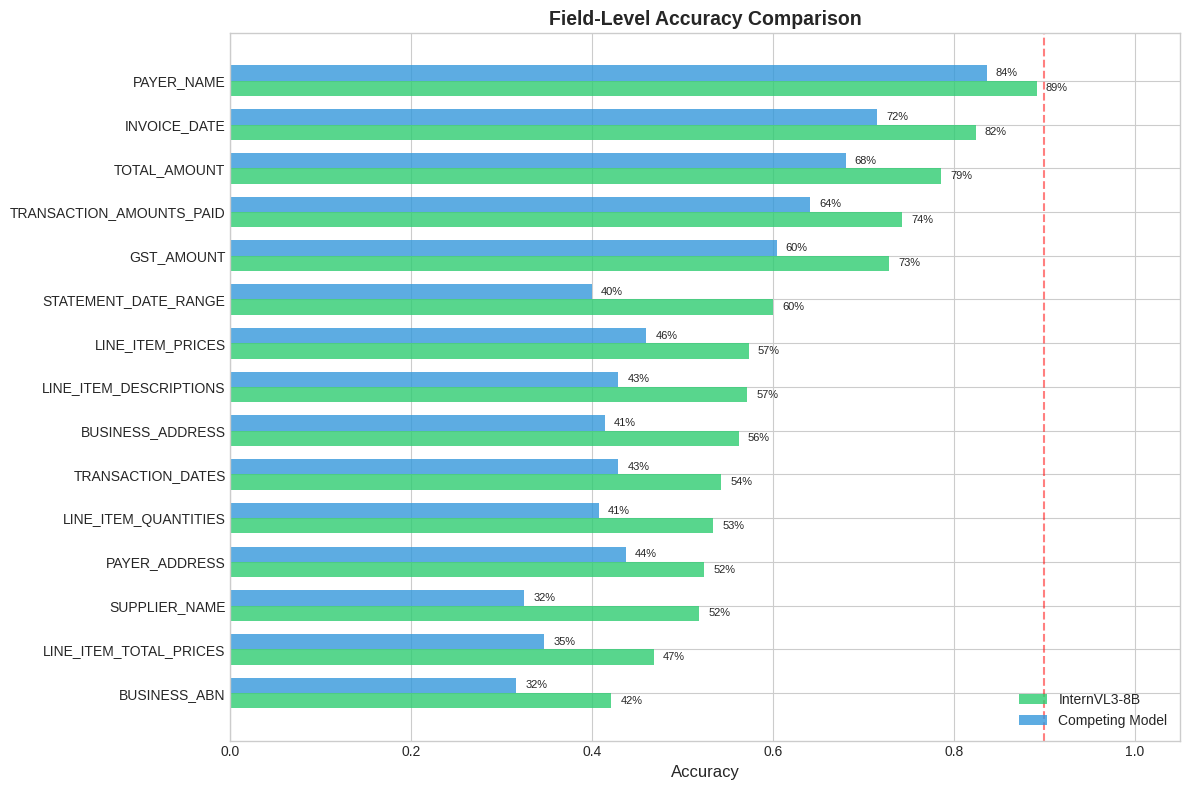

In [15]:
# Figure 1: Side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(plot_df))
bar_height = 0.35

bars1 = ax.barh(y_pos - bar_height/2, plot_df['current_accuracy'], bar_height, 
                label=CURRENT_MODEL_NAME, color='#2ecc71', alpha=0.8)
bars2 = ax.barh(y_pos + bar_height/2, plot_df['competing_accuracy'], bar_height,
                label=COMPETING_MODEL_NAME, color='#3498db', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['field'])
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Field-Level Accuracy Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 1.05)
ax.axvline(x=0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')

# Add value labels
for bar, val in zip(bars1, plot_df['current_accuracy']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.0%}', 
            va='center', fontsize=8)
for bar, val in zip(bars2, plot_df['competing_accuracy']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.0%}', 
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

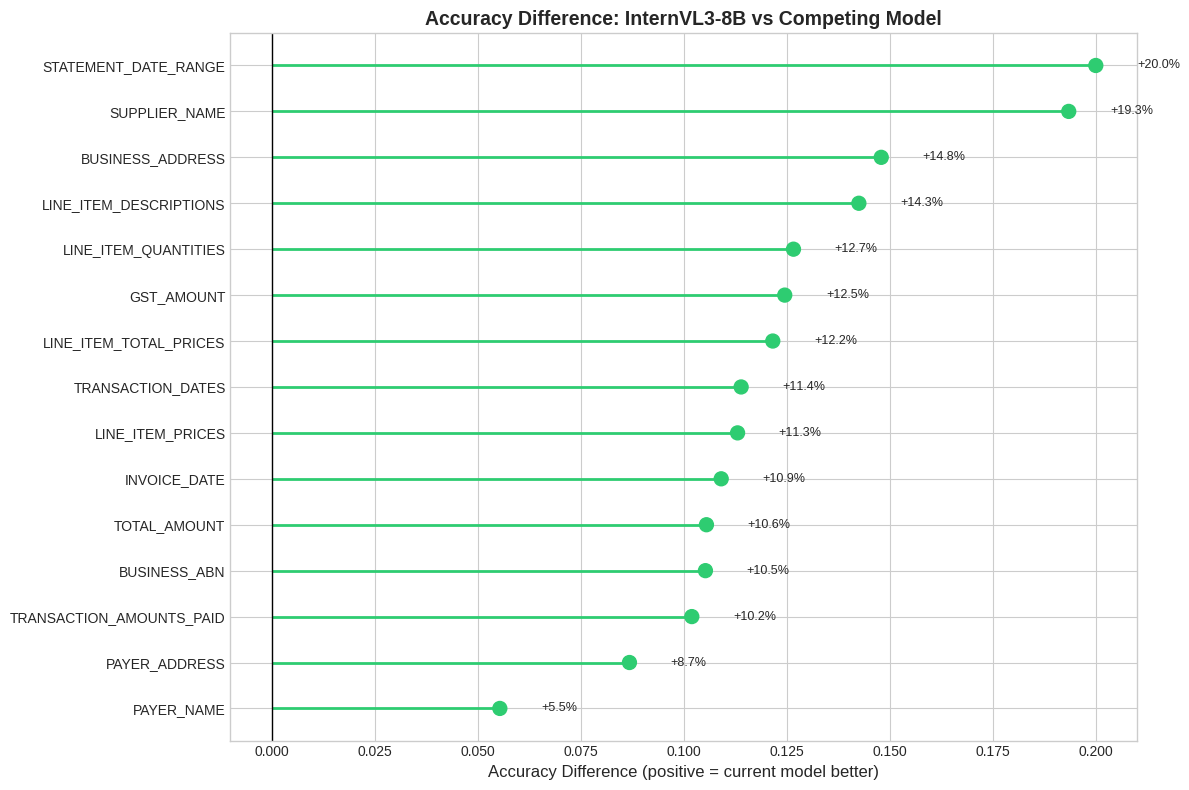

In [16]:
# Figure 2: Difference chart (lollipop plot)
fig, ax = plt.subplots(figsize=(12, 8))

# Sort by difference
diff_df = plot_df.sort_values('difference')
y_pos = np.arange(len(diff_df))

colors = ['#2ecc71' if d >= 0 else '#e74c3c' for d in diff_df['difference']]

ax.hlines(y=y_pos, xmin=0, xmax=diff_df['difference'], color=colors, linewidth=2)
ax.scatter(diff_df['difference'], y_pos, color=colors, s=100, zorder=3)

ax.set_yticks(y_pos)
ax.set_yticklabels(diff_df['field'])
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Accuracy Difference (positive = current model better)', fontsize=12)
ax.set_title(f'Accuracy Difference: {CURRENT_MODEL_NAME} vs {COMPETING_MODEL_NAME}', 
             fontsize=14, fontweight='bold')

# Add value labels
for y, diff in zip(y_pos, diff_df['difference']):
    ax.text(diff + 0.01 if diff >= 0 else diff - 0.01, y, f'{diff:+.1%}',
            va='center', ha='left' if diff >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_difference_lollipop.png', dpi=150, bbox_inches='tight')
plt.show()

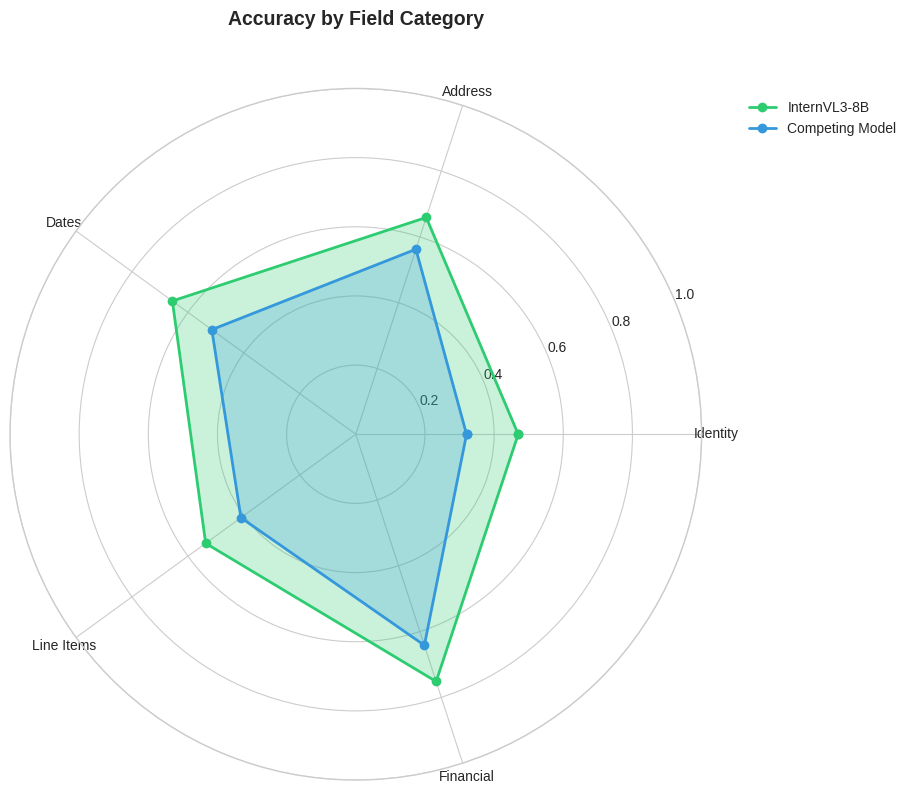

In [17]:
# Figure 3: Radar/Spider chart by category
def plot_radar_chart(df: pd.DataFrame, categories: dict, ax=None):
    """Plot radar chart comparing models by field category."""
    
    # Calculate category averages
    cat_data = []
    for cat, fields in categories.items():
        cat_df = df[df['field'].isin(fields)]
        if len(cat_df) > 0:
            cat_data.append({
                'category': cat,
                'current': cat_df['current_accuracy'].mean(),
                'competing': cat_df['competing_accuracy'].mean()
            })
    
    cat_df = pd.DataFrame(cat_data)
    
    # Radar chart setup
    categories_list = cat_df['category'].tolist()
    N = len(categories_list)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot current model
    values = cat_df['current'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=CURRENT_MODEL_NAME, color='#2ecc71')
    ax.fill(angles, values, alpha=0.25, color='#2ecc71')
    
    # Plot competing model
    values = cat_df['competing'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=COMPETING_MODEL_NAME, color='#3498db')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_list)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return ax

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
plot_radar_chart(comparison_df, FIELD_CATEGORIES, ax)
plt.title('Accuracy by Field Category', fontsize=14, fontweight='bold', y=1.08)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

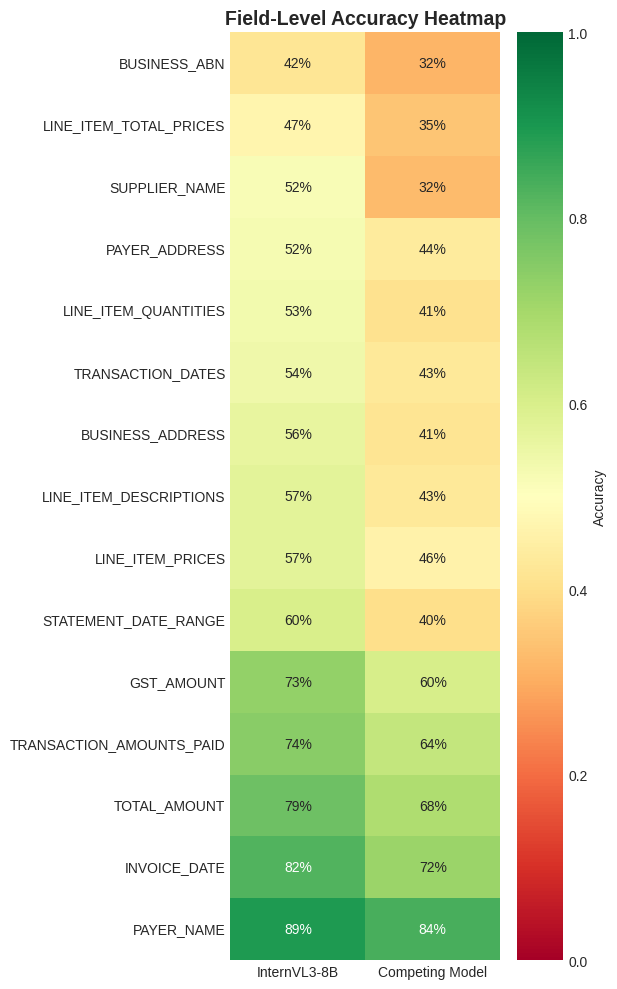

In [18]:
# Figure 4: Heatmap of accuracy values
fig, ax = plt.subplots(figsize=(6, 10))

heatmap_data = plot_df[['current_accuracy', 'competing_accuracy']].copy()
heatmap_data.index = plot_df['field']
heatmap_data.columns = [CURRENT_MODEL_NAME, COMPETING_MODEL_NAME]

sns.heatmap(heatmap_data, annot=True, fmt='.0%', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Field-Level Accuracy Heatmap', fontsize=14, fontweight='bold')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

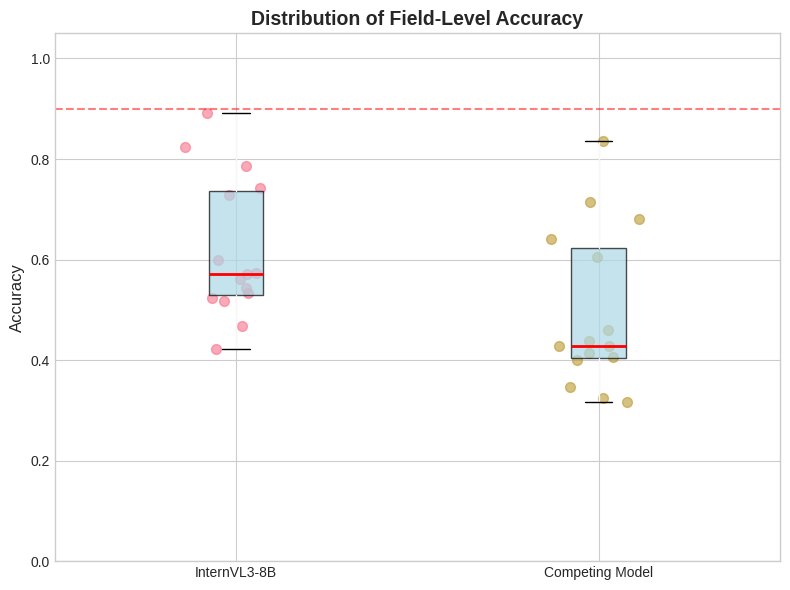

In [19]:
# Figure 5: Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = pd.DataFrame({
    CURRENT_MODEL_NAME: plot_df['current_accuracy'],
    COMPETING_MODEL_NAME: plot_df['competing_accuracy']
})

box_data.boxplot(ax=ax, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))

# Add individual points
for i, col in enumerate(box_data.columns, 1):
    y = box_data[col].dropna()
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=50)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Distribution of Field-Level Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

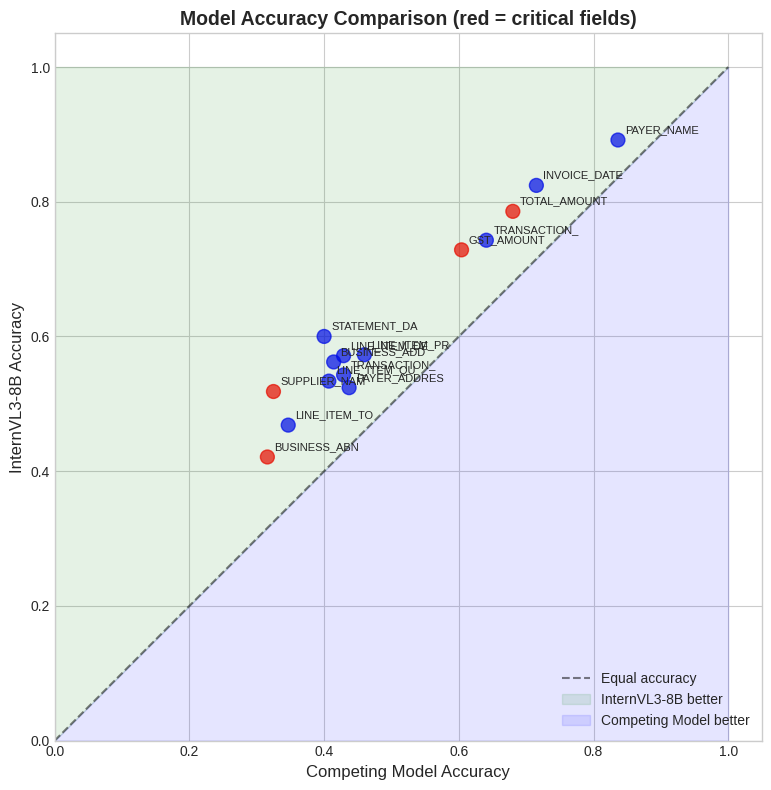

In [20]:
# Figure 6: Scatter plot with identity line
fig, ax = plt.subplots(figsize=(8, 8))

# Plot points
colors = ['red' if c else 'blue' for c in plot_df['is_critical']]
ax.scatter(plot_df['competing_accuracy'], plot_df['current_accuracy'], 
           c=colors, s=100, alpha=0.7)

# Add field labels
for _, row in plot_df.iterrows():
    ax.annotate(row['field'][:12], (row['competing_accuracy'], row['current_accuracy']),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

# Identity line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal accuracy')

# Fill regions
ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='green', label=f'{CURRENT_MODEL_NAME} better')
ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='blue', label=f'{COMPETING_MODEL_NAME} better')

ax.set_xlabel(f'{COMPETING_MODEL_NAME} Accuracy', fontsize=12)
ax.set_ylabel(f'{CURRENT_MODEL_NAME} Accuracy', fontsize=12)
ax.set_title('Model Accuracy Comparison (red = critical fields)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Category-Level Analysis

In [21]:
def analyze_by_category(df: pd.DataFrame, categories: dict) -> pd.DataFrame:
    """Analyze accuracy by field category."""
    results = []
    
    for cat, fields in categories.items():
        cat_df = df[df['field'].isin(fields)].dropna(subset=['current_accuracy', 'competing_accuracy'])
        
        if len(cat_df) > 0:
            results.append({
                'category': cat,
                'n_fields': len(cat_df),
                'current_mean': cat_df['current_accuracy'].mean(),
                'competing_mean': cat_df['competing_accuracy'].mean(),
                'difference': cat_df['difference'].mean(),
                'current_wins': (cat_df['difference'] > 0).sum(),
                'competing_wins': (cat_df['difference'] < 0).sum(),
            })
    
    return pd.DataFrame(results)

In [22]:
category_analysis = analyze_by_category(comparison_df, FIELD_CATEGORIES)

print("\n" + "=" * 80)
print("CATEGORY-LEVEL ANALYSIS")
print("=" * 80)

for _, row in category_analysis.iterrows():
    print(f"\n{row['category']} ({row['n_fields']} fields):")
    print(f"  {CURRENT_MODEL_NAME}:   {row['current_mean']:.1%}")
    print(f"  {COMPETING_MODEL_NAME}: {row['competing_mean']:.1%}")
    print(f"  Difference: {row['difference']:+.1%}")
    print(f"  Winner breakdown: {CURRENT_MODEL_NAME}={row['current_wins']}, {COMPETING_MODEL_NAME}={row['competing_wins']}")


CATEGORY-LEVEL ANALYSIS

Identity (2 fields):
  InternVL3-8B:   47.0%
  Competing Model: 32.0%
  Difference: +14.9%
  Winner breakdown: InternVL3-8B=2, Competing Model=0

Address (3 fields):
  InternVL3-8B:   65.9%
  Competing Model: 56.3%
  Difference: +9.7%
  Winner breakdown: InternVL3-8B=3, Competing Model=0

Dates (3 fields):
  InternVL3-8B:   65.6%
  Competing Model: 51.5%
  Difference: +14.1%
  Winner breakdown: InternVL3-8B=3, Competing Model=0

Line Items (4 fields):
  InternVL3-8B:   53.7%
  Competing Model: 41.1%
  Difference: +12.6%
  Winner breakdown: InternVL3-8B=4, Competing Model=0

Financial (3 fields):
  InternVL3-8B:   75.2%
  Competing Model: 64.2%
  Difference: +11.1%
  Winner breakdown: InternVL3-8B=3, Competing Model=0


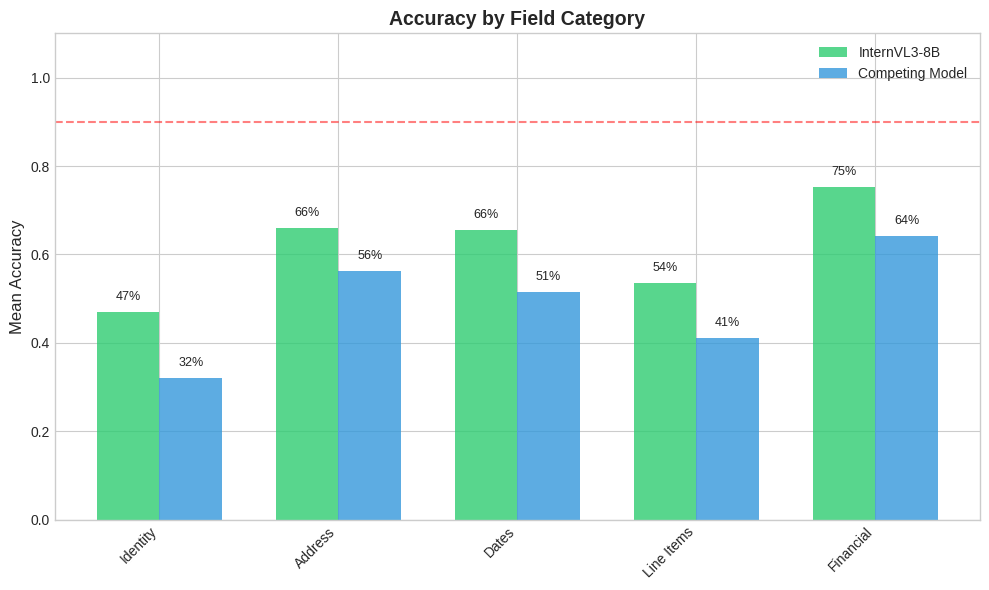

In [23]:
# Category comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(category_analysis))
width = 0.35

bars1 = ax.bar(x - width/2, category_analysis['current_mean'], width, 
               label=CURRENT_MODEL_NAME, color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, category_analysis['competing_mean'], width,
               label=COMPETING_MODEL_NAME, color='#3498db', alpha=0.8)

ax.set_ylabel('Mean Accuracy', fontsize=12)
ax.set_title('Accuracy by Field Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_analysis['category'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Export Results

In [24]:
# Export comparison DataFrame
comparison_df.to_csv(OUTPUT_DIR / 'field_comparison_results.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'field_comparison_results.csv'}")

# Export category analysis
category_analysis.to_csv(OUTPUT_DIR / 'category_comparison_results.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'category_comparison_results.csv'}")

Saved: ../output/comparison/field_comparison_results.csv
Saved: ../output/comparison/category_comparison_results.csv


In [25]:
# Generate summary report
report = f"""# Model Accuracy Comparison Report

## Overview
- **Current Model**: {CURRENT_MODEL_NAME}
- **Competing Model**: {COMPETING_MODEL_NAME}
- **Fields Compared**: {metrics['n_fields_compared']}
- **Document Types**: Invoices, Receipts, Bank Statements (195 documents)

## Summary Statistics

| Metric | {CURRENT_MODEL_NAME} | {COMPETING_MODEL_NAME} |
|--------|-----------|----------|
| Mean Accuracy | {metrics['current_mean']:.1%} | {metrics['competing_mean']:.1%} |
| Median Accuracy | {metrics['current_median']:.1%} | {metrics['competing_median']:.1%} |
| Std Dev | {metrics['current_std']:.1%} | {metrics['competing_std']:.1%} |
| Min | {metrics['current_min']:.1%} | {metrics['competing_min']:.1%} |
| Max | {metrics['current_max']:.1%} | {metrics['competing_max']:.1%} |

## Comparison Results

- **Mean Difference**: {metrics['mean_difference']:+.1%} (positive = {CURRENT_MODEL_NAME} better)
- **Fields where {CURRENT_MODEL_NAME} better**: {metrics['fields_current_better']}
- **Fields where {COMPETING_MODEL_NAME} better**: {metrics['fields_competing_better']}
- **Fields equal**: {metrics['fields_equal']}

## Critical Fields Analysis

Critical fields: {', '.join(CRITICAL_FIELDS)}

- **{CURRENT_MODEL_NAME} Mean**: {metrics['critical_current_mean']:.1%}
- **{COMPETING_MODEL_NAME} Mean**: {metrics['critical_competing_mean']:.1%}

## Statistical Significance

- **Paired t-test p-value**: {stat_results['paired_ttest']['pvalue']:.4f} ({'Significant' if stat_results['paired_ttest']['pvalue'] < 0.05 else 'Not significant'} at α=0.05)
- **Wilcoxon test p-value**: {stat_results['wilcoxon']['pvalue']:.4f} ({'Significant' if stat_results['wilcoxon']['pvalue'] < 0.05 else 'Not significant'} at α=0.05)
- **Cohen's d effect size**: {stat_results['cohens_d']:.4f} ({effect_interp})
- **95% CI for difference**: [{stat_results['bootstrap_ci_95'][0]:+.1%}, {stat_results['bootstrap_ci_95'][1]:+.1%}]

## Field-Level Details

| Field | {CURRENT_MODEL_NAME} | {COMPETING_MODEL_NAME} | Difference |
|-------|-----------|----------|------------|
"""

for _, row in comparison_df.iterrows():
    curr = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
    comp = f"{row['competing_accuracy']:.1%}" if pd.notna(row['competing_accuracy']) else "N/A"
    diff = f"{row['difference']:+.1%}" if pd.notna(row['difference']) else "N/A"
    critical = " ⚠️" if row['is_critical'] else ""
    report += f"| {row['field']}{critical} | {curr} | {comp} | {diff} |\n"

report += f"""
## Output Files

- `field_comparison_results.csv` - Detailed field-level comparison
- `category_comparison_results.csv` - Category-level aggregation
- `accuracy_comparison_bars.png` - Side-by-side bar chart
- `accuracy_difference_lollipop.png` - Difference visualization
- `accuracy_radar_chart.png` - Category radar chart
- `accuracy_heatmap.png` - Heatmap comparison
- `accuracy_boxplot.png` - Distribution comparison
- `accuracy_scatter.png` - Scatter plot with identity line
"""

# Save report
report_path = OUTPUT_DIR / 'comparison_report.md'
with open(report_path, 'w') as f:
    f.write(report)

print(f"Saved: {report_path}")
print("\n" + "=" * 60)
print("COMPARISON COMPLETE")
print("=" * 60)

Saved: ../output/comparison/comparison_report.md

COMPARISON COMPLETE


---
## 9. Quick Reference: Data Format Requirements

### Competing Model CSV Format

The notebook accepts multiple CSV formats:

**Format A - Single row with field columns:**
```csv
DOCUMENT_TYPE,BUSINESS_ABN,SUPPLIER_NAME,...
0.95,0.87,0.92,...
```

**Format B - Field and Accuracy columns:**
```csv
Field,Accuracy
DOCUMENT_TYPE,95.0
BUSINESS_ABN,87.0
...
```

**Format C - Any column names (case-insensitive):**
```csv
field_name,accuracy_score
document_type,0.95
...
```

### Current Model Data Sources

1. **per_field_metrics.csv** - Direct field-level accuracy from evaluation pipeline
2. **batch_results_*.csv** - Per-image results (will be aggregated automatically)